## Linear SVM (soft-margin)

Let's create some data. In this case, we'll generate data this separable.

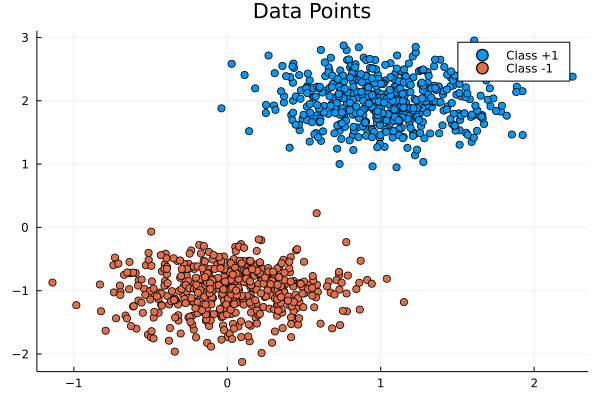

In [22]:
using Plots, Random

#Set random seed so this notebook always has the same results
Random.seed!(0)

dim = 2;
numsamples = 1000;

mean1 = [1; 2]
mean2 = [0; -1]

#Generate two sets of samples with different means
#randn(2,500) creates a matrix of size 2x500 of
#normally distributed random numbers
samples1 = mean1 .+ 0.35*randn(2,500)
samples2 = mean2 .+ 0.35*randn(2,500)

#Combine two groups of samples, matrix is 2 rows by 1000 columns
#First 500 columns are +1 class, second 500 columns are -1 class
samples = [samples1 samples2]
#Label first 500 +1, second 500 -1
labels = [ones(500); -1*ones(500)]

plot(samples[1,1:500], samples[2,1:500], seriestype = :scatter, label = "Class +1")
plot!(samples[1,501:1000], samples[2,501:1000], seriestype = :scatter, title = "Data Points", label = "Class -1")

Now let's set up our SVM code.

In [23]:
using JuMP, Ipopt

lambdavals = [5, 500, 10000]

wout = zeros(2,3)
bout = zeros(3)

i = 1

for λ in lambdavals
    m = Model(Ipopt.Optimizer)
    #Create variables, the variables η represent how much a specific
    #sample is on the wrong side of the supporting vector
    @variable(m, w[1:dim])
    @variable(m, b)
    @variable(m, η[1:numsamples] >= 0)

    #Add one constraint per sample, which is ``soft" in the sense that η can always be made
    #large enough to satisfy it
    @constraint(m, epigraph[i in 1:numsamples], labels[i]*(w'*samples[:,i] + b) >= 1 - η[i])

    #Minimize our quadratic objective, trading off between our two goals with parameter λ
    @objective(m, Min, (1/2)*w'*w + (λ/numsamples)*sum(η[i] for i in 1:numsamples))

    #We can print the model, but it has 1000 constraints, so it's a bit difficult to read...
    #print(m)

    optimize!(m);

    wout[:,i] = value.(w)
    bout[i] = value.(b)

    i = i+1
end
;

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4000
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:     1003
                     variables with only lower bounds:     1000
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.9999950e-02 9.90e-01 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

Let's plot our results!

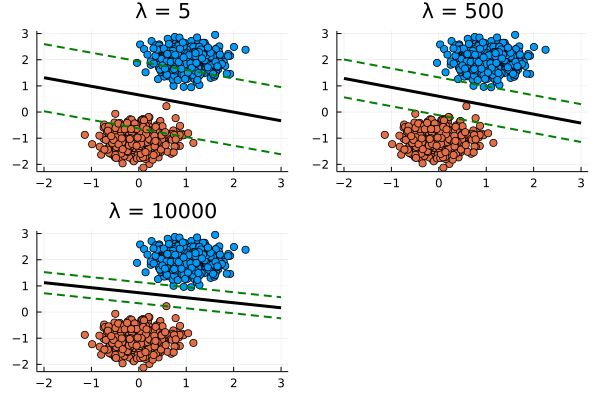

In [24]:
xline = LinRange(-2, 3, 1000)
yline = zeros(1000, 3)
ylines1 = zeros(1000, 3)
ylines2 = zeros(1000, 3)

for i in 1:3
    #Separating hyperplane
    yline[:,i] = -(wout[1,i].*xline .+ bout[i])/wout[2,i]
    #Supporting hyperplane 1
    ylines1[:,i] = -(wout[1,i].*xline .+ bout[i] .+ 1)/wout[2,i]
    #Supporting hyperplane 2
    ylines2[:,i] = -(wout[1,i].*xline .+ bout[i] .- 1)/wout[2,i]
end

plot1 = plot(samples[1,1:500], samples[2,1:500], seriestype = :scatter, label = "Class +1")
plot1 = plot!(samples[1,501:1000], samples[2,501:1000], seriestype = :scatter, title = "λ = 5", label = "Class -1")
plot1 = plot!(xline, yline[:,1], lw = 3, label = "Separating Hyperplane", seriescolor = :black)
plot1 = plot!(xline, ylines1[:,1], lw = 2, label = "Supporting Hyperplane", linestyle = :dash, seriescolor = :green)
plot1 = plot!(xline, ylines2[:,1], lw = 2, label = "Supporting Hyperplane", linestyle = :dash, seriescolor = :green)

plot2 = plot(samples[1,1:500], samples[2,1:500], seriestype = :scatter, label = "Class +1")
plot2 = plot!(samples[1,501:1000], samples[2,501:1000], seriestype = :scatter, title = "λ = 500", label = "Class -1")
plot2 = plot!(xline, yline[:,2], lw = 3, label = "Separating Hyperplane", seriescolor = :black)
plot2 = plot!(xline, ylines1[:,2], lw = 2, label = "Supporting Hyperplane", linestyle = :dash, seriescolor = :green)
plot2 = plot!(xline, ylines2[:,2], lw = 2, label = "Supporting Hyperplane", linestyle = :dash, seriescolor = :green)

plot3 = plot(samples[1,1:500], samples[2,1:500], seriestype = :scatter, label = "Class +1")
plot3 = plot!(samples[1,501:1000], samples[2,501:1000], seriestype = :scatter, title = "λ = 10000", label = "Class -1")
plot3 = plot!(xline, yline[:,3], lw = 3, label = "Separating Hyperplane", seriescolor = :black)
plot3 = plot!(xline, ylines1[:,3], lw = 2, label = "Supporting Hyperplane", linestyle = :dash, seriescolor = :green)
plot3 = plot!(xline, ylines2[:,3], lw = 2, label = "Supporting Hyperplane", linestyle = :dash, seriescolor = :green)

plot(plot1, plot2, plot3, layout = (2, 2), legend = false)

Now let's generate an example that is not separable.

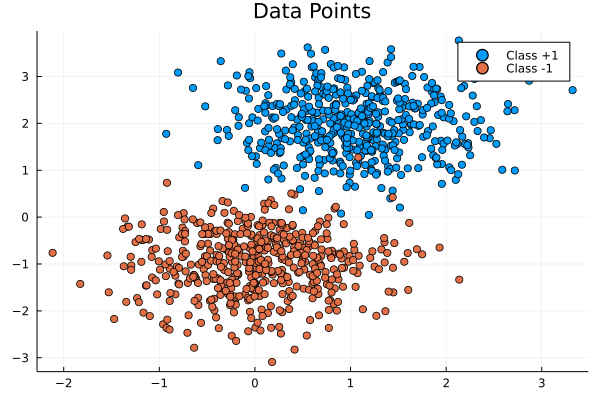

In [25]:
using Plots, Random

#Set random seed so this notebook always has the same results
Random.seed!(0)

dim = 2;
numsamples = 1000;

mean1 = [1; 2]
mean2 = [0; -1]

#Generate two sets of samples with different means
#randn(2,500) creates a matrix of size 2x500 of normally distributed random
#numbers
samples1 = mean1 .+ 0.65*randn(2,500)
samples2 = mean2 .+ 0.65*randn(2,500)

#Combine two groups of samples, matrix is 2 rows by 1000 columns
#First 500 columns are +1 class, second 500 columns are -1 class
samples = [samples1 samples2]
#Label first 500 +1, second 500 -1
labels = [ones(500); -1*ones(500)]

plot(samples[1,1:500], samples[2,1:500], seriestype = :scatter, label = "Class +1")
plot!(samples[1,501:1000], samples[2,501:1000], seriestype = :scatter, title = "Data Points", label = "Class -1")

In [26]:
λ = 100

m = Model(Ipopt.Optimizer)
#Create variables, the variables η represent how much a specific
#sample is on the wrong side of the supporting vector
@variable(m, w[1:dim])
@variable(m, b)
@variable(m, η[1:numsamples] >= 0)

#Add one constraint per sample, which is ``soft" in the sense that η can always be made
#large enough to satisfy it
@constraint(m, epigraph[i in 1:numsamples], labels[i]*(w'*samples[:,i] + b) >= 1 - η[i])

#Minimize our quadratic objective, trading off between our two goals with parameter λ
@objective(m, Min, (1/2)*w'*w + (λ/numsamples)*sum(η[i] for i in 1:numsamples))

#We can print it, but it has 1000 constraints, so it's a bit difficult to read...
#print(m)

optimize!(m);

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4000
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:     1003
                     variables with only lower bounds:     1000
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.9999900e-01 9.90e-01 1.05e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

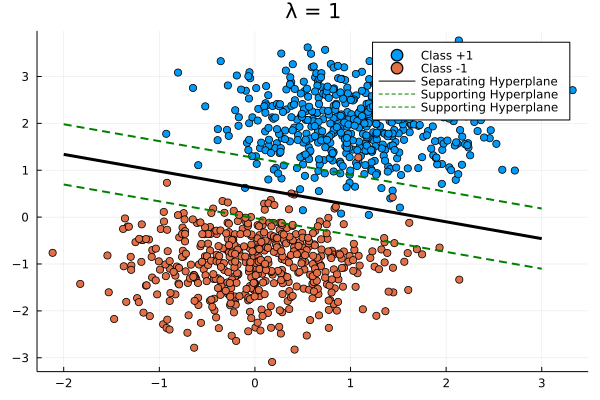

In [27]:
xline = LinRange(-2, 3, 1000)
wout = value.(w)
bout = value.(b)

yline = -(wout[1].*xline .+ bout)/wout[2]
#Supporting hyperplane 1
ylines1 = -(wout[1].*xline .+ bout .+ 1)/wout[2]
#Supporting hyperplane 2
ylines2 = -(wout[1].*xline .+ bout .- 1)/wout[2]

plot1 = plot(samples[1,1:500], samples[2,1:500], seriestype = :scatter, label = "Class +1")
plot1 = plot!(samples[1,501:1000], samples[2,501:1000], seriestype = :scatter, title = "λ = 100", label = "Class -1")
plot1 = plot!(xline, yline, lw = 3, label = "Separating Hyperplane", seriescolor = :black)
plot1 = plot!(xline, ylines1, lw = 2, label = "Supporting Hyperplane", linestyle = :dash, seriescolor = :green)
plot1 = plot!(xline, ylines2, lw = 2, label = "Supporting Hyperplane", linestyle = :dash, seriescolor = :green)